# Memory experiment: Compute $ \langle \bar{0} | \bar{Z} | \bar{0} \rangle$ with the five-qubit code

In [1]:
import collections
from typing import List, Dict, Sequence
import itertools
import functools

import numpy as np
import cirq
import qiskit
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

from mitiq import PauliString
import stim
import stimcirq

from encoded.LST import int_to_bin_list

In [2]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set parameters

In [3]:
n = 5                                   # Number of physical qubits
nshots = 20_000                         # Number of samples/shots
depths = list(range(0, 100 + 1, 10))    # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.
# obs: str = "Z"  # TODO: Add.
ibm_computer: str = "ibm_fez"
use_simulator: bool = False

In [4]:
# Computer and qubits to use.
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend(ibm_computer)

if use_simulator:
    from qiskit_aer import AerSimulator


    computer = AerSimulator().from_backend(computer)
sampler = Sampler(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    5 : [3, 16, 22, 23, 24],
    # 7: [99, 100, 101, 110, 117, 118, 119]
    # 7 : [3, 2, 1, 0, 14, 18, 19],
}


# Good qubits in Sherbrooke Jan 24.
# layout = {
#     7 : [99, 100, 101, 110, 117, 118, 119],
# }

## Helper functions

In [5]:
def int_to_bin_str(x, length):
    return functools.reduce(lambda a, b: a + b, [str(b) for b in int_to_bin_list(x, length)])


def get_counts_for(qubit: int, counts: collections.Counter[str, int]) -> collections.Counter[int, int]:
    qubit_counts = collections.Counter()
    for key, value in counts.items():
        k = list(key)[qubit]
        qubit_counts[int(k)] += value
    return qubit_counts


# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    # print("In compute expectation:")
    # print("pauli =", pauli)
    # print("counts =")
    # print(counts)
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    # print("indices = ", indices)
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    eval = pauli.coefficient * expectation / sum(counts.values())
    return float(np.real_if_close(eval))

def parity_check_matrix_to_stabilizers(matrix: np.ndarray) -> List[stim.PauliString]:
    num_rows, num_cols = matrix.shape
    assert num_cols % 2 == 0
    num_qubits = num_cols // 2

    matrix = matrix.astype(np.bool8)  # indicate the data isn't bit packed
    return [
        stim.PauliString.from_numpy(
            xs=matrix[row, :num_qubits],
            zs=matrix[row, num_qubits:],
        )
        for row in range(num_rows)
    ]

# Prepares logical |0> state on Steane Code
def encode_five(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    a= stim.PauliString("+ZX_XZ")
    b=stim.PauliString("+XZZX_")
    c= stim.PauliString("+_XZZX")
    d=stim.PauliString("+X_XZZ")
    # a= stim.PauliString("+XZZX_")
    # b=stim.PauliString("+_XZZX")
    # c= stim.PauliString("+X_XZZ")
    # d=stim.PauliString("+ZX_XZ")
    tableau = stim.Tableau.from_stabilizers(
        [a, b, c, d],
        allow_underconstrained=True,
    )
    stim_circuit = tableau.to_circuit(method='graph_state')
    circuit = stimcirq.stim_circuit_to_cirq_circuit(stim_circuit)
    circuit.append(cirq.X.on_each(qreg))
    
    return circuit

def noisy_identity(qreg, depth):
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

In [6]:
qreg = cirq.LineQubit.range(n)

to_run_raw = []
for depth in depths:
    circuit = noisy_identity(qreg, depth)

    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
    circuit.measure_active()
    # Compile to device.
    compiled_raw = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[n],
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=0,
    )
    to_run_raw.append(compiled_raw)
to_run_raw[-1].draw(fold=-1, idle_wires=False)

┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ ░ ┌─┐            
  q_0 -> 3 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─┤M├────────────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░ └╥┘┌─┐         
 q_1 -> 16 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫─┤M├─────────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░  ║ └╥┘┌─┐      
 q_2 -> 22 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░──╫──╫─┤M├──────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░  ║  ║ └╥┘┌─┐   
 q_3 -> 23 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├

In [7]:
job_raw = sampler.run(
    to_run_raw,
    shots=nshots,
)

In [17]:
all_counts_raw = [result.data.measure.get_counts() for result in job_raw.result()]

In [18]:
all_evals = {}

for i, q in enumerate(layout[n]):
    evals = []
    for counts in all_counts_raw:
        counts = get_counts_for(i, counts)
        eval = (counts.get(0, 0) - counts.get(1, 0)) / nshots
        evals.append(eval)
    all_evals[q] = evals

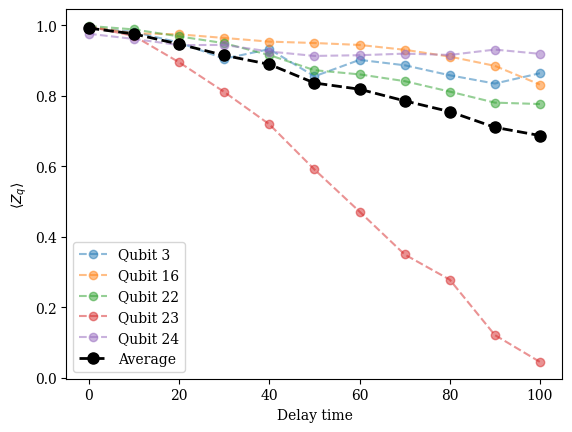

In [19]:
for qubit, evals in all_evals.items():
    plt.plot(depths, evals, "--o", alpha=0.5, label=f"Qubit {qubit}")

evals_raw_avg = np.array(list(all_evals.values())).mean(axis=0)
plt.plot(depths, evals_raw_avg, "--o", ms=8, lw=2, color="black", label="Average")
plt.xlabel("Delay time")
plt.ylabel(r"$\langle Z_q \rangle$")
plt.legend();
# plt.savefig("physical_evals_delay_gate_test.pdf")

# Run encoded experiment

In [8]:
generator_strs = [
    "XZZXI",
    "IXZZX",
    "XIXZZ",
    "ZXIXZ",
]
# generator_strs = [
#     "ZXIXZ",
#     "XZZXI",
#     "IXZZX",
#     "XIXZZ",
# ]
observable = PauliString("Z" * n)._pauli

qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_elements = generate_stabilizer_elements(stabilizer_generators)
# for stab in stabilizer_elements:
#     print(stab)

observable_elements = [stab * observable for stab in stabilizer_elements]
# for obs in observable_elements:
#     print(obs)

In [9]:
qreg = cirq.LineQubit.range(n)
circuit = encode_five(qreg)

print(circuit)

# Hacky fix to replace non-unitary RX gates at the start of the Stim circuit to Hadamard gates.
circuit = cirq.Circuit(
    cirq.H.on_each(qreg),
    circuit[1:],
)
# circuit.append(cirq.H.on_each(qreg))
circuit

0: ───RX───@───@───────────────H───X───
           │   │
1: ───RX───┼───┼───@───@───────H───X───
           │   │   │   │
2: ───RX───@───┼───┼───┼───@───H───X───
               │   │   │   │
3: ───RX───────@───@───┼───┼───H───X───
                       │   │
4: ───RX───────────────@───@───H───X───


0: ───H───@───@───────────────H───X───
          │   │
1: ───H───┼───┼───@───@───────H───X───
          │   │   │   │
2: ───H───@───┼───┼───┼───@───H───X───
              │   │   │   │
3: ───H───────@───@───┼───┼───H───X───
                      │   │
4: ───H───────────────@───@───H───X───

## Compute the numerator ($\langle \tilde{O} \rangle$)

In [10]:
all_to_run = {}
all_to_run_list = []
for depth in depths:
    print("Status: On depth", depth)

    circuit = circuit.copy()
    # =============================
    # Build numerator circuits.
    # =============================
    num_circuits = []
    for pauli in observable_elements:
        c = circuit.copy()
        # print(pauli)
        for q, p in pauli.items():
            if p is cirq.X:
                c.append(cirq.H.on(q))
            elif p is cirq.Y:
                c.append(cirq.S.on(q)**-1)
                c.append(cirq.H.on(q))
        qc = qiskit.QuantumCircuit.from_qasm_str(c.to_qasm())
        qubits = get_active_qubits(qc)
        qc.barrier(qubits)
        for _ in range(depth):
            qc.x(qubits)
            qc.barrier(qubits)
        qc.measure_active()
        num_circuits.append(qc)
    
    compiled_num = [
        qiskit.transpile(
            circuit,
            backend=computer,
            initial_layout=layout[n],
            optimization_level=3,
        ) for circuit in num_circuits
    ]

    # ===========================
    # Build denominator circuits.
    # ===========================
    den_circuits = []
    for pauli in stabilizer_elements:
        c = circuit.copy()
        for q, p in pauli.items():
            if p is cirq.X:
                c.append(cirq.H.on(q))
            elif p is cirq.Y:
                c.append(cirq.S.on(q)**-1)
                c.append(cirq.H.on(q))
        qc = qiskit.QuantumCircuit.from_qasm_str(c.to_qasm())
        qubits = get_active_qubits(qc)
        qc.barrier(qubits)
        for _ in range(depth):
            qc.x(qubits)
            qc.barrier(qubits)
        qc.measure_active()
        den_circuits.append(qc)

    compiled_den = [
        qiskit.transpile(
            circuit,
            backend=computer,
            initial_layout=layout[n],
            optimization_level=3
        ) for circuit in den_circuits
    ]

    # =================================================================
    # Collect all numerator and denominator circuits to run in one job.
    # =================================================================
    to_run = compiled_num + compiled_den
    all_to_run[depth] = to_run
    all_to_run_list.extend(to_run)

Status: On depth 0
Status: On depth 10
Status: On depth 20
Status: On depth 30
Status: On depth 40
Status: On depth 50
Status: On depth 60
Status: On depth 70
Status: On depth 80
Status: On depth 90
Status: On depth 100


## Run all depths on noisy simulator

In [ ]:
len(all_to_run_list)

In [30]:
if use_simulator:
    job_all = sampler.run(all_to_run_list, shots=nshots)
    counts_all = [result.data.measure.get_counts() for result in job_all.result()]

### Post-process results

In [34]:
nobservables = len(observable_elements)
results = list(np.array(counts_all).reshape(len(depths), len(observable_elements) + len(stabilizer_elements)))

In [ ]:
encoded_values = []

for depth, result in zip(depths, results):
    all_counts_num = result[:nobservables]
    all_counts_den = result[nobservables:]

    evals_numerator = []
    for pauli, counts in zip(observable_elements, all_counts_num):
        # print(pauli)
        eval = compute_expectation(pauli, counts)
        # print(eval)
        evals_numerator.append(eval)
    
    evals_denominator = []
    for pauli, counts in zip(stabilizer_elements, all_counts_den):
        # print(pauli)
        eval = compute_expectation(pauli, counts)
        # print(eval)
        evals_denominator.append(eval)
    
    lst_value = sum(evals_numerator) / sum(evals_denominator)
    encoded_values.append(lst_value)
    print(f"Encoded value at depth {depth}:", lst_value)

## Plotting

In [ ]:
for qubit, evals in all_evals.items():
    plt.plot(depths, evals, "--o", alpha=0.40, mec="black", label=f"Qubit {qubit}")

evals_raw_avg = np.array(list(all_evals.values())).mean(axis=0)
plt.plot(depths, evals_raw_avg, "--o", ms=8, alpha=0.75, lw=1.5, color="xkcd:blue", mec="black", label="Average")

plt.plot(depths, encoded_values, "--s", ms=10, color="black", mec="black", alpha=0.75, label="Encoded")
plt.axhline(1.0, color="xkcd:darkgreen", label="Ideal")

plt.xlabel("Depth")
plt.ylabel(r"$\langle Z \rangle$")
plt.legend();
# plt.savefig("physical_evals_delay_gate_test.pdf")

## Run some results on hardware

In [37]:
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

In [38]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [12]:
len(all_to_run[0])

32

In [20]:
# job_hardware0 = sampler.run(all_to_run[0], shots=nshots)
job_hardware0 = service.job('cv462q0f113c738agvpg')

In [ ]:
job_hardware0.inputs["pubs"][1][0].draw(fold=-1, idle_wires=False)

In [21]:
nobservables = len(observable_elements)

In [22]:
counts_hardware = [result.data.measure.get_counts() for result in job_hardware0.result()]
all_counts_num = counts_hardware[:nobservables]
all_counts_den = counts_hardware[nobservables:]

evals_numerator = []
for pauli, counts in zip(observable_elements, all_counts_num):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_numerator.append(eval)

evals_denominator = []
for pauli, counts in zip(stabilizer_elements, all_counts_den):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_denominator.append(eval)

hardware0 = sum(evals_numerator) / sum(evals_denominator)
hardware0

0.996310866748823

In [ ]:
len(all_to_run[10])

In [23]:
# job_hardware10 = sampler.run(all_to_run[10], shots=nshots)
job_hardware10 = service.job("cv4632jgvb2s73a12ut0")

In [ ]:
job_hardware10.inputs["pubs"][1][0].draw(fold=-1, idle_wires=False)

In [24]:
counts_hardware = [result.data.measure.get_counts() for result in job_hardware10.result()]
all_counts_num = counts_hardware[:nobservables]
all_counts_den = counts_hardware[nobservables:]

evals_numerator = []
for pauli, counts in zip(observable_elements, all_counts_num):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_numerator.append(eval)

evals_denominator = []
for pauli, counts in zip(stabilizer_elements, all_counts_den):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_denominator.append(eval)

hardware10 = sum(evals_numerator) / sum(evals_denominator)
hardware10

0.9985735197466691

In [13]:
len(all_to_run[50])

32

In [14]:
job_hardware50 = sampler.run(all_to_run[50], shots=nshots)

In [25]:
counts_hardware = [result.data.measure.get_counts() for result in job_hardware50.result()]
all_counts_num = counts_hardware[:nobservables]
all_counts_den = counts_hardware[nobservables:]

evals_numerator = []
for pauli, counts in zip(observable_elements, all_counts_num):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_numerator.append(eval)

evals_denominator = []
for pauli, counts in zip(stabilizer_elements, all_counts_den):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_denominator.append(eval)

hardware50 = sum(evals_numerator) / sum(evals_denominator)
hardware50

0.986267549049685

In [15]:
len(all_to_run[100])

32

In [16]:
job_hardware100 = sampler.run(all_to_run[100], shots=nshots)

In [26]:
counts_hardware = [result.data.measure.get_counts() for result in job_hardware100.result()]
all_counts_num = counts_hardware[:nobservables]
all_counts_den = counts_hardware[nobservables:]

evals_numerator = []
for pauli, counts in zip(observable_elements, all_counts_num):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_numerator.append(eval)

evals_denominator = []
for pauli, counts in zip(stabilizer_elements, all_counts_den):
    # print(pauli)
    eval = compute_expectation(pauli, counts)
    # print(eval)
    evals_denominator.append(eval)

hardware100 = sum(evals_numerator) / sum(evals_denominator)
hardware100

0.8902716817600977

In [27]:
stop: int = 11

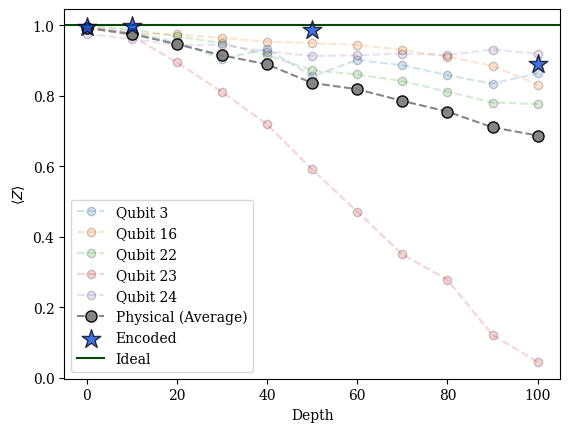

In [29]:
for qubit, evals in all_evals.items():
    plt.plot(depths[:stop], evals[:stop], "--o", alpha=0.20, mec="black", label=f"Qubit {qubit}")

evals_raw_avg = np.array(list(all_evals.values())).mean(axis=0)
plt.plot(depths[:stop], evals_raw_avg[:stop], "--o", ms=8, alpha=0.95, lw=1.5, color="grey", mec="black", label="Physical (Average)")

# plt.plot(depths[:stop], encoded_values[:stop], "--s", ms=8, color="lightblue", mec="black", alpha=0.75, label="Encoded (Simulator)")

plt.scatter(0, hardware0, alpha=0.75, color="xkcd:blue", ec="black", marker="*", s=200, label="Encoded", zorder=3)
plt.scatter(10, hardware10, alpha=0.75, color="xkcd:blue", ec="black", marker="*", s=200, zorder=3)
plt.scatter(50, hardware50, alpha=0.75, color="xkcd:blue", ec="black", marker="*", s=200, zorder=3)
plt.scatter(100, hardware100, alpha=0.75, color="xkcd:blue", ec="black", marker="*", s=200, zorder=3)
# plt.scatter(200, hardware200, alpha=0.75, color="xkcd:blue", ec="black", marker="*", s=200, zorder=3)

plt.axhline(1.0, color="xkcd:darkgreen", label="Ideal")

plt.xlabel("Depth")
plt.ylabel(r"$\langle Z \rangle$")
plt.legend();
plt.savefig("five_qubit_memory_separate_circuits.pdf")

## Save data

In [30]:
import os

import pickle

In [31]:
save_key = f"memory_five_qubit_code_zero_state_z_separate_circuits_{computer.name}_{time_key}_job_raw_id_{job_raw.job_id()}"

In [32]:
os.mkdir(save_key)

In [33]:
np.savetxt(f"{save_key}/physical_qubits.txt", layout[n])
np.savetxt(f"{save_key}/depths.txt", depths)
np.savetxt(f"{save_key}/nshots.txt", [nshots])

In [34]:
with open(f"{save_key}/expectation_values_raw.pkl", "wb") as f:
    pickle.dump(all_evals, f)

In [35]:
evals_encoded_depths = [0, 10, 50, 100]
evals_encoded = [hardware0, hardware10, hardware50, hardware100]

np.savetxt(f"{save_key}/evals_encoded_depths.txt", evals_encoded_depths)
np.savetxt(f"{save_key}/evals_encoded.txt", evals_encoded)